In [1]:
 %matplotlib inline
!python -m pip uninstall matplotlib -Y
!pip install matplotlib==3.1.3
!pip install wandb


Usage:   
  /Users/eamonmcandrew/opt/anaconda3/envs/scINTEGRATION/bin/python -m pip uninstall [options] <package> ...
  /Users/eamonmcandrew/opt/anaconda3/envs/scINTEGRATION/bin/python -m pip uninstall [options] -r <requirements file> ...

no such option: -Y


In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scanpy as sc
import plotly.express as px
import plotly.io as pio
import sklearn.preprocessing
import sklearn.model_selection





torch.autograd.set_detect_anomaly(True)

In [3]:
import platform

def get_device_and_gmount():
    # Get the operating system and version
    os = platform.system()
    version = platform.release()

    # Get the machine's architecture
    arch = platform.machine()

    # Set the default renderer based on the operating system
    if os == 'Darwin':
        pio.renderers.default = 'notebook'
        print("Using Apple MPS on Macbook Pro")
    
    elif os == 'Linux':
        pio.renderers.default = 'colab'
        print("Using Colab on Linux")

    # Set the device based on the machine's architecture
    if arch == 'x86_64':
        device = torch.device('mps') if os == 'Darwin' else torch.device('cuda')
        gmount = True if os == 'Linux' else False
    else:
        device = torch.device('cpu')
        gmount = False

    print("Using device:", device)
    
    return device, gmount


In [4]:
device, gmount = get_device_and_gmount()


Using Apple MPS on Macbook Pro
Using device: mps


In [5]:
if gmount:
    from google.colab import drive
    drive.mount('/content/drive')
    scdata = sc.read_h5ad("/content/drive/MyDrive/scintegration/GEX.h5ad")
else:
    scdata = sc.read_h5ad("/Users/eamonmcandrew/Desktop/Single_cell_integration/Data/Multi-ome/GEX.h5ad")

In [6]:
def stratified_split(data, test_size, random_state, split_criteria):
    """
    Splits the data into train and test sets stratified by the batch column
    """
    train = []
    test = []
    for batch in data.obs[split_criteria].unique():
        batch_data = data[data.obs[split_criteria] == batch]
        batch_train, batch_test = sklearn.model_selection.train_test_split(batch_data, test_size=test_size, random_state=random_state)
        batch_train, batch_test = list(batch_train.obs.index), list(batch_test.obs.index)
        train.extend(batch_train)
        test.extend(batch_test)
        
    return train, test


In [7]:
if gmount == True:
    from google.colab import drive
    drive.mount('/content/drive')
    scdata = sc.read_h5ad("/content/drive/MyDrive/scintegration/GEX.h5ad")

In [8]:
import wandb
wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eamomc. Use `wandb login --relogin` to force relogin


True

In [9]:
class GEX_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, scaler=None, cat_var=None, label_encoder=None):
        self.data = data
        self.values = np.asarray(data.X.todense())
        self.cat_var = cat_var

        label_encoder_functions = {
            "numeric": lambda: torch.tensor(sklearn.preprocessing.LabelEncoder().fit_transform(self.data.obs[self.cat_var]), dtype=torch.long),
            "range_map": lambda: sklearn.preprocessing.LabelEncoder().fit_transform(self.data.obs[self.cat_var]).reshape(-1, 1),
            "one_hot": lambda: sklearn.preprocessing.OneHotEncoder().fit_transform(sklearn.preprocessing.LabelEncoder().fit_transform(self.data.obs[self.cat_var]).reshape(-1, 1)).toarray()
        }

        if label_encoder in label_encoder_functions:
            cat_var_data = label_encoder_functions[label_encoder]()
            if label_encoder == "range_map":
                cat_var_data = torch.tensor(sklearn.preprocessing.MinMaxScaler().fit_transform(cat_var_data), dtype=torch.float32)
            elif label_encoder == "one_hot":
                cat_var_data = torch.tensor(cat_var_data, dtype=torch.float32)
        else:
            cat_var_data = None
        self.cat_var_data = cat_var_data

        scaler_functions = {
            "Standard": lambda: sklearn.preprocessing.StandardScaler().fit_transform(self.values),
            "MinMax": lambda: sklearn.preprocessing.MinMaxScaler().fit_transform(self.values)
        }

        if scaler in scaler_functions:
            self.scaled_values = torch.tensor(scaler_functions[scaler](), dtype=torch.float32)
        else:
            self.scaled_values = torch.tensor(self.values, dtype=torch.float32)

    @property
    def n_features(self):
        return self.values.shape[1]

    @property
    def n_catagories(self):
        return self.cat_var_data.shape[1] if self.cat_var_data is not None else 0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.scaled_values[idx], self.cat_var_data[idx]


In [10]:
def stratified_split(data, test_size, random_state, split_criteria):
    """
    Splits the data into train and test sets stratified by the batch column
    """
    train = []
    test = []
    for batch in data.obs[split_criteria].unique():
        batch_data = data[data.obs[split_criteria] == batch]
        batch_train, batch_test = sklearn.model_selection.train_test_split(batch_data, test_size=test_size, random_state=random_state)
        batch_train, batch_test = list(batch_train.obs.index), list(batch_test.obs.index)
        train.extend(batch_train)
        test.extend(batch_test)
        
    return train, test


In [11]:
class Generator(nn.Module):
  def __init__(self, input_size, dropout, hidden_sizes, output_size, use_batch_norm):
    super().__init__()
    
    self.input_size = input_size
    self.dropout = dropout
    self.hidden_sizes = hidden_sizes
    self.output_size = output_size
    self.use_batch_norm = use_batch_norm

    # create a list of layers
    layers = []

    # input layer
    layers.append(nn.Linear(self.input_size, self.hidden_sizes[0]))
    if self.use_batch_norm:
      layers.append(nn.BatchNorm1d(self.hidden_sizes[0]))
    layers.append(nn.ReLU())
    if self.dropout > 0:
      layers.append(nn.Dropout(p=self.dropout))

    # hidden layers
    for i in range(1, len(self.hidden_sizes)):
      layers.append(nn.Linear(self.hidden_sizes[i-1], self.hidden_sizes[i]))
      if self.use_batch_norm:
        layers.append(nn.BatchNorm1d(self.hidden_sizes[i]))
      layers.append(nn.ReLU())
      if self.dropout > 0:
        layers.append(nn.Dropout(p=self.dropout))

    # output layer
    layers.append(nn.Linear(self.hidden_sizes[-1], self.output_size))
    layers.append(nn.Sigmoid())

    # create the model using Sequential
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)


In [12]:
class Discriminator(nn.Module):
  def __init__(self, input_size, dropout, hidden_sizes, output_size, use_batch_norm):
    super().__init__()
    
    self.input_size = input_size
    self.dropout = dropout
    self.hidden_sizes = hidden_sizes
    self.output_size = output_size
    self.use_batch_norm = use_batch_norm

    # create a list of layers
    layers = []

    # input layer
    layers.append(nn.Linear(self.input_size, self.hidden_sizes[0]))
    if self.use_batch_norm:
      layers.append(nn.BatchNorm1d(self.hidden_sizes[0]))
    layers.append(nn.LeakyReLU(0.2))
    if self.dropout > 0:
      layers.append(nn.Dropout(p=self.dropout))

    # hidden layers
    for i in range(1, len(self.hidden_sizes)):
      layers.append(nn.Linear(self.hidden_sizes[i-1], self.hidden_sizes[i]))
      if self.use_batch_norm:
        layers.append(nn.BatchNorm1d(self.hidden_sizes[i]))
      layers.append(nn.LeakyReLU(0.2))
      if self.dropout > 0:
        layers.append(nn.Dropout(p=self.dropout))

    # output layer
    layers.append(nn.Linear(self.hidden_sizes[-1], self.output_size))
    layers.append(nn.Sigmoid())

    # create the model using Sequential
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)


In [13]:
# Define the GAN model
class GAN(nn.Module):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, x):
        return self.discriminator(self.generator(x))

In [14]:
def generate_fake_data_and_combine(original_data, generator, z_dim, batch_size):
    generator.eval()
    noise = torch.randn(batch_size, z_dim)
    fake_data = generator(noise)
    fake_adata = sc.AnnData(fake_data.detach().numpy())

    # add an index column to the fake data, starting at the number of real cells
    fake_adata.var.index = scdata.var.index
    adata = sc.AnnData.concatenate(original_data, fake_adata)
    # add a "group" column to the observations DataFrame,
    # with the value "real" for the real cells and "fake" for the fake cells
    adata.obs['group'] = ['real' if i < len(scdata.obs) else 'fake' for i in range(len(adata.obs))]

    # compute the UMAP of the combined data
    sc.pp.neighbors(adata, n_neighbors=10)
    sc.tl.umap(adata)

    return adata

In [15]:
def plot_umap_by_group(adata):
    plot = sc.pl.umap(adata, color='group', legend_loc='on data', show=False)
    return plot 

In [16]:
def get_noise(n_samples, z_dim, device=device):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim,device=device)


In [17]:
def train_gan_one_epoch(epoch, GEX_dataloader_train, gan, g_opt, d_opt, criterion, z_dim):
    gan.generator.to(device)
    gan.discriminator.to(device)
    gan.train()
    total_loss_discriminator = 0
    total_loss_generator = 0
    for iteration, (data, _) in enumerate(GEX_dataloader_train):
        data = data.to(device)
        # Generate fake data
        noise = get_noise(data.shape[0], z_dim, device=device)
        fake_data = gan.generator(noise)

        fake_data = fake_data.to(device)

        # Train the discriminator
        d_opt.zero_grad()
        pred_real = gan.discriminator(data)
        pred_fake = gan.discriminator(fake_data.detach())
        loss_real = criterion(pred_real, torch.ones_like(pred_real))
        loss_fake = criterion(pred_fake, torch.zeros_like(pred_fake))
        loss_discriminator = (loss_real + loss_fake) / 2
        loss_discriminator.backward(retain_graph=True)
        wandb.log({"loss_discriminator": loss_discriminator})
        d_opt.step()

        # Train the generator
        g_opt.zero_grad()
        noise = get_noise(data.shape[0], z_dim, device=device)
        pred_fake = gan.discriminator(fake_data)
        loss_generator = criterion(pred_fake, torch.ones_like(pred_fake))
        loss_generator.backward()
        wandb.log({"loss_generator": loss_generator})
        g_opt.step()

        total_loss_discriminator += loss_discriminator.item()
        total_loss_generator += loss_generator.item()

    num_iterations = len(GEX_dataloader_train)
    mean_loss_discriminator = total_loss_discriminator / num_iterations
    mean_loss_generator = total_loss_generator / num_iterations

    return mean_loss_discriminator, mean_loss_generator



In [ ]:
def initalise_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [18]:
config = wandb.config = {
    "lr": 0.001,
    "batch_size": 64,
    "epochs": 60,
    "random_seed": 42,
    "dropout_G": 0.1,
    "dropout_D": 0.2,
    "split_criteria": "cell_type",
    "eval_size_percentage": 0.1,
    "hidden_sizes_G": [32, 64, 128],
    "hidden_sizes_D": [32, 64, 128],
    "use_batch_norm_G": True,
    "use_batch_norm_D": True,
    "z_dim": 100,
}


In [19]:
def train_func(config):
    
    if config is not None:
        run = wandb.init(project="Single Cell Omics integration", entity="scintegration", config=config)

    else:
      run = wandb.init(project="Single Cell Omics integration", entity="scintegration", config = config)
    

    # Load the learning rate, batch size, epochs, random seed, dropout, and hidden size from the wandb configuration

    lr = wandb.config.lr
    batch_size = wandb.config.batch_size
    epochs = wandb.config.epochs
    random_seed = wandb.config.random_seed
    dropout_G = wandb.config.dropout_G
    dropout_D = wandb.config.dropout_D
    split_criteria = wandb.config.split_criteria
    eval_size_percentage = wandb.config.eval_size_percentage
    hidden_sizes_G = wandb.config.hidden_sizes_G
    hidden_sizes_D = wandb.config.hidden_sizes_D
    use_batch_norm_G = wandb.config.use_batch_norm_G
    use_batch_norm_D = wandb.config.use_batch_norm_D
    z_dim = wandb.config.z_dim


    train, test = stratified_split(scdata, 0.2, wandb.config.random_seed, split_criteria=split_criteria)
    train_data = scdata[train]
    test_data = scdata[test]


    GEX_Dataset_train = GEX_Dataset(train_data, scaler="Standard", cat_var="batch", label_encoder="one_hot")
    GEX_dataloader_train = torch.utils.data.DataLoader(GEX_Dataset_train, batch_size = batch_size, shuffle = True)

    GEX_Dataset_test = GEX_Dataset(test_data, scaler="Standard", cat_var="batch", label_encoder="one_hot")
    GEX_dataloader_test = torch.utils.data.DataLoader(GEX_Dataset_test, batch_size = batch_size, shuffle = True)

    output_size = GEX_Dataset_test.n_features
    target_size = GEX_Dataset_test.n_features

    # Create instance of the generator and discriminator networks
    generator = Generator(output_size=target_size, input_size=z_dim, hidden_sizes=hidden_sizes_G, dropout=dropout_G, use_batch_norm=use_batch_norm_G)
    generator = generator.to(device)


    discriminator = Discriminator(input_size=target_size, output_size=1, hidden_sizes=hidden_sizes_D, use_batch_norm = use_batch_norm_D, dropout=dropout_D)
    discriminator = discriminator.to(device)


    gan = GAN(generator, discriminator)
    gan = gan.to(device)
    
    # initialize the weights of the generator and discriminator networks
    initialize_weights(generator)
    

    loss_fn = nn.BCELoss()
    d_opt = torch.optim.Adam(gan.discriminator.parameters(), lr=lr)
    g_opt = torch.optim.Adam(gan.generator.parameters(), lr=lr)


    sc.pp.neighbors(test_data, n_neighbors=10)
    sc.tl.umap(test_data)
    test_UMAP = sc.pl.umap(test_data, color="cell_type", show=False)
    wandb.log({"Test UMAP": wandb.Image(test_UMAP)})
    # Create instance of the GAN model
    
    gan.train()
    for epoch in range(1,epochs):
      D_loss_train, G_loss_train = train_gan_one_epoch(epoch, GEX_dataloader_train, gan, g_opt, d_opt, loss_fn, z_dim)
      wandb.log({"D_loss_train": D_loss_train, "G_loss_train": G_loss_train})
      if epoch % 3 == 0:
        umap_data = generate_fake_data_and_combine(test_data, generator, z_dim, batch_size)
        umap = plot_umap_by_group(umap_data)
        wandb.log({"UMAP": umap})

      




wandb: Currently logged in as: eamomc (scintegration). Use `wandb login --relogin` to force relogin


         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/eamonmcandrew/opt/anaconda3/envs/scINTEGRATION/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning:

Error detected in NativeBatchNormBackward0. Traceback of forward call that caused the error:
  File "/Users/eamonmcandrew/opt/anaconda3/envs/scINTEGRATION/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/eamonmcandrew/opt/anaconda3/envs/scINTEGRATION/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/eamonmcandrew/opt/anaconda3/envs/scINTEGRATION/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/eamonmcandrew/opt/anaconda3/envs/scINTEGRATION/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/Users/eamonmcandrew/opt/anaconda3/e

RuntimeError: Function 'NativeBatchNormBackward0' returned nan values in its 0th output.

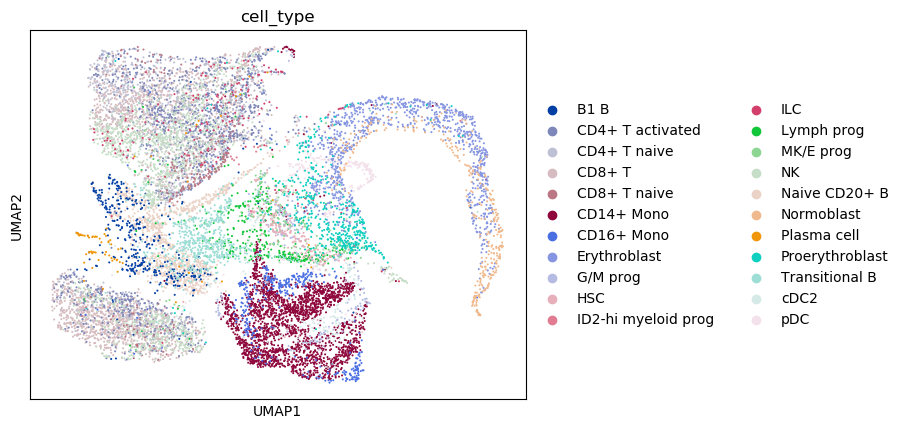

In [20]:
train_func(config=config)